# I. Install and import libraries

In [ ]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!echo '{"username":"rohitawate","key":"14a69194fa4cd4e37490796b1f37ff69"}' > ~/.kaggle/kaggle.json

!kaggle datasets download -d kartik2112/fraud-detection
!unzip -o fraud-detection.zip
!pip install feature_engine imbalanced_learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from feature_engine.encoding import WoEEncoder, RareLabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import os

 99% 200M/202M [00:06<00:00, 49.5MB/s]
100% 202M/202M [00:06<00:00, 32.5MB/s]
Archive:  fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          
     |████████████████████████████████| 260 kB 4.3 MB/s 
     |████████████████████████████████| 9.8 MB 20.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
column_dtypes = {
    'cc_num':'object',
    'zip': 'object'
}

df = pd.read_csv('fraudTrain.csv', index_col=0, dtype=column_dtypes, parse_dates=['trans_date_trans_time', 'dob'])

In [ ]:
X = df.copy()
y = X.pop('is_fraud')

#  II. Load the dataset

In [ ]:
pd.set_option('display.max_columns', None)

# III. EDA and feature engineering

In [ ]:
# Source: https://stackoverflow.com/a/29546836/6948907

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def is_weekend(txn_time):
    return int(txn_time.weekday() >= 5)

def is_night(txn_time):
    return int(txn_time.hour <= 6 or txn_time.hour >= 22)

def get_txn_history(txns, windows=[7, 15, 30, 60]):
    txns = txns.sort_values('trans_date_trans_time')
    txns.index = txns.trans_date_trans_time
    
    for window in windows:
        total_amt = txns['amt'].rolling(window, min_periods = 1).sum()
        count_amt = txns['amt'].rolling(window, min_periods = 1).count()

        avg_amt = total_amt/count_amt

        txns[f'count_amt_{window}_days'] = list(count_amt)
        txns[f'count_avg_{window}_days'] = list(avg_amt)

    txns.reset_index(drop = True)
    return txns

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

class Transformer:
    def __init__(self):
        self.zip_fraud_count = {}
        self.job_fraud_count = {}
        self.merchant_fraud_count = {}
        self.sm = SMOTE()

        
    def fit_zip_score(self, df, y):
        for idx, zip in df['zip'].iteritems():
            if y[idx] == 1:
                if zip in self.zip_fraud_count:
                    self.zip_fraud_count[zip] += 1
                else:
                    self.zip_fraud_count[zip] = 1
            else:
                if not zip in self.zip_fraud_count:
                    self.zip_fraud_count[zip] = 0

    def fit_job_score(self, df, y):
        for idx, job in df['job'].iteritems():
            if y[idx] == 1:
                if job in self.job_fraud_count:
                    self.job_fraud_count[job] += 1
                else:
                    self.job_fraud_count[job] = 1
            else:
                if not job in self.job_fraud_count:
                    self.job_fraud_count[job] = 0

    def fit_merchant_score(self, df, y):
        for idx, merchant in df['merchant'].iteritems():
            if y[idx] == 1:
                if merchant in self.merchant_fraud_count:
                    self.merchant_fraud_count[merchant] += 1
                else:
                    self.merchant_fraud_count[merchant] = 1
            else:
                if not merchant in self.merchant_fraud_count:
                    self.merchant_fraud_count[merchant] = 0

    def fit(self, df, y):
        self.fit_zip_score(df, y)
        self.fit_job_score(df, y)
        self.fit_merchant_score(df, y)

    def transform(self, df):
        df = df.groupby('cc_num').apply(lambda x: get_txn_history(x, windows=[1,7,15,30, 60]))
        df.reset_index(drop=True, inplace = True)
        df = df.sort_values('trans_date_trans_time')

        df['distance_bet_user_merchant'] = haversine_np(df['lat'],df['long'],df['merch_lat'],df['merch_long'])
        df['user_age'] = (df['trans_date_trans_time'] - df['dob']).astype('<m8[Y]').apply(pd.to_numeric)
        df['txn_at_night'] = df['trans_date_trans_time'].apply(lambda txn_time: is_night(txn_time))
        df['txn_on_weekend'] = df['trans_date_trans_time'].apply(lambda txn_time: is_weekend(txn_time))
        df['zip_score']= df['zip'].apply(lambda zip: self.zip_fraud_count.get(zip, 0))
        df['job_score']= df['job'].apply(lambda job: self.job_fraud_count.get(job, 0))
        df['merchant_count'] = df['merchant'].apply(lambda merchant: self.merchant_fraud_count.get(merchant, 0))

        df.drop(axis=1, inplace=True, columns=[
                    'trans_num', 'street', 'first', 'last', 'unix_time', 'city', 'state',
                    'trans_date_trans_time', 'dob',  'cc_num', 'zip', 'merchant'
                ]
            )
        return df

    def oversample(self, x, y):
        return self.sm.fit_resample(x, y.ravel())

transformer = Transformer()
transformer.fit(X, y)
X = transformer.transform(X)


In [ ]:
y.value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [ ]:
X.head()

,category,amt,gender,lat,long,city_pop,job,merch_lat,merch_long,count_amt_1_days,count_avg_1_days,count_amt_7_days,count_avg_7_days,count_amt_15_days,count_avg_15_days,count_amt_30_days,count_avg_30_days,count_amt_60_days,count_avg_60_days,distance_bet_user_merchant,user_age,txn_at_night,txn_on_weekend,zip_score,job_score,merchant_count
151135,misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,1.0,4.97,1.0,4.97,1.0,4.97,1.0,4.97,1.0,4.97,96.708914,30.0,1,0,0,6,18
1204733,grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,1.0,107.23,1.0,107.23,1.0,107.23,1.0,107.23,1.0,107.23,14.491400,40.0,1,0,0,11,27
652244,entertainment,220.11,M,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,1.0,220.11,1.0,220.11,1.0,220.11,1.0,220.11,1.0,220.11,42.453757,56.0,1,0,0,8,4
383686,gas_transport,45.00,M,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,1.0,45.00,1.0,45.00,1.0,45.00,1.0,45.00,1.0,45.00,60.187449,51.0,1,0,15,20,9
598484,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,1.0,41.96,1.0,41.96,1.0,41.96,1.0,41.96,1.0,41.96,92.438680,32.0,1,0,0,0,6


In [ ]:
rare_encoder = RareLabelEncoder(tol=0.005, n_categories=2, variables=['category','gender','job'])
X_encoded = rare_encoder.fit_transform(X)
woe_encoder = WoEEncoder(variables=['category','gender','job'])
woe_encoder.fit(X_encoded , y)

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable gender is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)


ValueError: ignored

In [ ]:
def transform_X(X):
    X_encoded = rare_encoder.transform(X)
    return woe_encoder.transform(X_encoded)

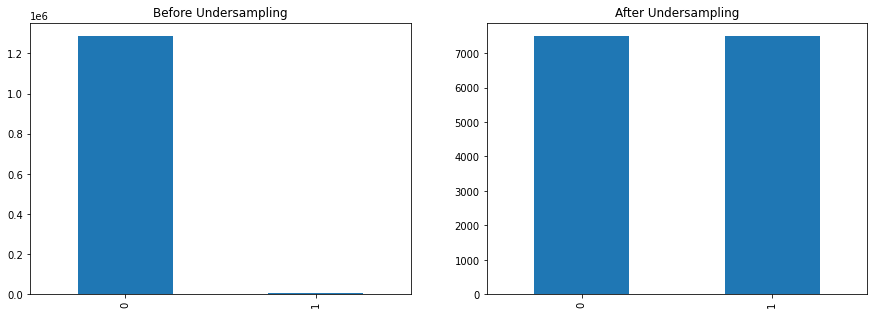

In [ ]:
# woe_encoder.encoder_dict_
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before Undersampling')
pd.Series(y).value_counts().plot.bar(ax=ax1)

rus = RandomUnderSampler(random_state=42)
X_resample, y_resample = rus.fit_resample(X,y)

ax2.set_title('After Undersampling') 
pd.Series(y_resample).value_counts().plot.bar(ax=ax2)
plt.show()

In [ ]:
# X_resample.head()

In [ ]:
# X_resample['y'] = y_resample
# X_resample.corr()['y'].abs().sort_values(ascending=False)

In [ ]:
# X = transform_X(X)

# X_resample, y_resample = transformer.oversample(X, y)


# IV. Prepare data for modeling

In [ ]:
# Because there are not many records labeled 1, I will undersample to balance the data and reduce training time
rus = RandomUnderSampler(random_state=42)
X_resample, y_resample = rus.fit_resample(transform_X(X), y)

# V. Train model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
parameters = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10]}
clf = LogisticRegression()
# clf = RandomForestClassifier()
# clf = GridSearchCV(rf, paramteres, scoring='accuracy', cv=5)
clf.fit(X_resample, y_resample)
# rf.fit(X_resample, y_resample)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

# VI. Test and plot results

In [ ]:
df_test = pd.read_csv('fraudTest.csv', index_col=0, dtype=column_dtypes, parse_dates=['trans_date_trans_time', 'dob'])
X_test = df_test.copy()
y_test = X_test.pop('is_fraud')


X_test = transformer.transform(X_test)
X_test = transform_X(X_test)
X_test_resample, y_test_resample = rus.fit_resample(X_test, y_test)

In [ ]:
clf.score(X_test_resample, y_test_resample)

0.9030303030303031

In [ ]:
X_resample.head()

,category,amt,gender,lat,long,city_pop,job,merch_lat,merch_long,transactions_count_1day_window,transactions_average1day_window,transactions_count_7day_window,transactions_average7day_window,transactions_count_15day_window,transactions_average15day_window,transactions_count_30day_window,transactions_average30day_window,distance_bet_user_merchant,user_age,txn_at_night,txn_on_weekend,zip_score,job_score,merchant_count
0,-0.005463,86.19,-0.010865,34.0287,-118.4924,92043,-0.011392,33.287851,-118.740970,1.0,86.19,7.0,154.540000,15.0,117.767333,30.0,170.607667,48.142480,58.0,0,1,0,10,8
1,-0.077197,85.81,-0.010865,36.7154,-89.6287,1019,-0.011392,36.539950,-89.857416,1.0,85.81,7.0,51.678571,15.0,38.907333,30.0,41.390667,25.416212,41.0,0,0,14,21,4
2,0.021281,99.30,-0.010865,39.9636,-79.7853,184,-0.160392,39.582872,-78.838550,1.0,99.30,7.0,35.395714,15.0,44.594000,30.0,53.058667,105.499337,74.0,0,0,0,13,28
3,-0.112867,42.09,-0.010865,48.2777,-112.8456,743,-0.011392,48.310513,-112.837535,1.0,42.09,7.0,115.751429,15.0,86.262667,30.0,58.992667,1.675330,47.0,0,1,0,0,6
4,0.057742,4.24,-0.010865,36.4715,-82.4834,87124,-0.011392,37.329094,-82.070746,1.0,4.24,7.0,49.950000,15.0,65.408667,30.0,77.575333,47.609720,32.0,0,0,5,19,36


In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test_resample)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix_test = confusion_matrix(y_test_resample, y_pred)

In [ ]:
cf_matrix_train = confusion_matrix(y_resample, clf.predict(X_resample))

In [ ]:
cf_matrix_train

array([[7179,  327],
       [1117, 6389]])

In [ ]:
cf_matrix_test

array([[2059,   86],
       [ 330, 1815]])

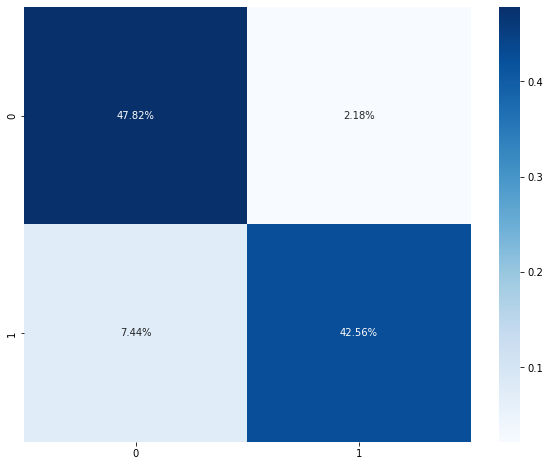

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix_train/np.sum(cf_matrix_train), annot=True, 
            fmt='.2%', cmap='Blues')

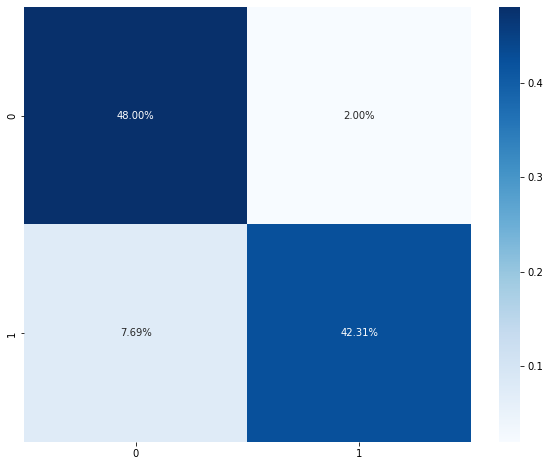

In [ ]:
# [[530708,  22866],
#        [   331,   1814]]
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
from sklearn import metrics

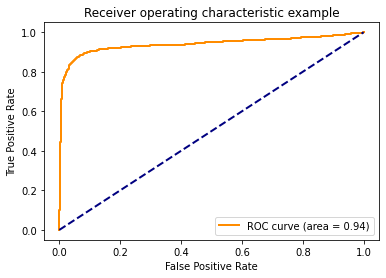

In [ ]:
#define metrics
y_pred_proba = clf.predict_proba(X_test_resample)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_resample,  y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()